In [58]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import convolve
import time
import pickle
import numba 

In [127]:
def A_B(un, a, b, domain, dim, tau, kappa):
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    dx_minus = convolve(un.reshape(dim[0], dim[1]), K_dx_minus)
    dx_plus = convolve(un.reshape(dim[0], dim[1]), K_dx_plus)
    dy_minus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_plus).T
    dy_plus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_minus).T

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2+np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2+np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :] = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0] = 0
    norm_grad[:, -1] = 0

#     cache_harmonic_mean = {}
#     def harmonic_mean(un, p, m):
#         ix = domain.index(p)
#         jx = domain.index(m)
#         if (ix, jx) not in cache_harmonic_mean.keys():
#             cache_harmonic_mean[(ix, jx)] = 2 / ( (norm_grad[p]/b[ix]) + (norm_grad[m]/b[jx]) )
#             cache_harmonic_mean[(jx, ix)] = cache_harmonic_mean[(ix, jx)]
#         return cache_harmonic_mean[(ix, jx)]
    K_x_minus  = np.array([
            [0,  0, 0],
            [1, 1, 0],
            [0,  0, 0]
        ])
    K_x_plus  = np.array([
            [0,  0, 0],
            [0, 1, 1],
            [0,  0, 0]
        ])
    x_minus = convolve(norm_grad, K_x_minus)
    x_plus = convolve(norm_grad, K_x_plus)
    y_minus = convolve(norm_grad.T, K_x_plus).T
    y_plus = convolve(norm_grad.T, K_x_minus).T
    
    hm_x_minus = (2/x_minus) 
    hm_x_minus[np.isclose(norm_grad, 0)] = 0
    hm_x_plus = (2/x_plus) 
    hm_x_plus[np.isclose(norm_grad, 0)] = 0
    hm_y_minus = (2/y_minus) 
    hm_y_minus[np.isclose(norm_grad, 0)] = 0
    hm_y_plus = (2/y_plus) 
    hm_y_plus[np.isclose(norm_grad, 0)] = 0
    
    hm_sum = hm_x_minus + hm_x_plus + hm_y_minus + hm_y_plus
    print(hm_sum)
    
    get_sigma =  - a.reshape((dim[0], dim[1])) * norm_grad * hm_sum
        
    def neighbours(p, l="x"):
        px, py = p
        if l == "x":
            o = [ (px, py-1), (px, py+1) ]
            
        elif l == "y":
            o = [ (px-1, py), (px+1, py) ]
            
        return [m  for m in o if m in domain]
    
#     def get_sigma(p):
#         ix = domain.index(p)
#         norm_grad_p = norm_grad[p]
#         if np.isclose(norm_grad_p, 0):
#             return 0
#         else:
#             sum_N = sum( harmonic_mean(un, p, m) for m in neighbours(p, l="x") + neighbours(p, l="y") )
#             return - a[ix] * norm_grad_p * sum_N
    
    def get_delta(p, m):
        norm_grad_p = norm_grad[p]
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            d_p_m = [m[0]-p[0], m[1]-p[1]]
            if d_p_m[0] == 1:
                return a[ix] * norm_grad_p * hm_y_plus[p]
            if d_p_m[0] == -1:
                return a[ix] * norm_grad_p * hm_y_minus[p]
            if d_p_m[1] == 1:
                return a[ix] * norm_grad_p * hm_x_plus[p]
            if d_p_m[1] == -1:
                return a[ix] * norm_grad_p * hm_x_minus[p]
            
    
    def get_A_row(row):
        
        px = row
        start = time.time()
        
        D   = [ get_sigma[ (px, c) ]             for c in range( dim[1]     ) ]
        print("D:", time.time()-start)
        start = time.time()
        
        D1  = [ get_delta( (px, c), (px, c+1) )  for c in range( dim[1] - 1 ) ]
        print("D1:", time.time()-start)
        start = time.time()
        
        D_1 = [ get_delta( (px, c), (px, c-1) )  for c in range( 1, dim[1]  ) ]
        print("D_1:", time.time()-start)
    
        
        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        
        D = [ get_delta( (px, c), (px+star, c) ) for c in range( dim[1] ) ]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
    D1 =  [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])
    
    I = csr_matrix(np.eye(un.shape[0]))
    A_star = I - tau * csr_matrix(A0+A1+A2)
#     A_star = I
    B_star = np.array( [un[domain.index(p)] + tau*kappa*norm_grad[p]*a[domain.index(p)] for p in domain] )

    return A_star, B_star, norm_grad
    

In [121]:
test = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])
test[0, :] = 0
test[-1, :] = 0
test[:, 0] = 0
test[:, -1] = 0
test

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

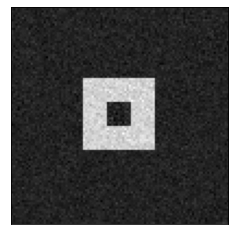

In [93]:
dim = (100, 100)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

img = np.random.normal(0.4, 0.005, size=dim[0] * dim[1])
for i in range(dim[0]//3):
    for j in range(dim[1]//3):
        img[(i+dim[0]//3)*dim[1]+j+dim[1]//3] += np.random.normal(0.1, 0.005)

for i in range(dim[0]//9):
    for j in range(dim[1]//9):
        img[(i+4*dim[0]//9)*dim[1]+j+4*dim[1]//9] -= np.random.normal(0.1, 0.005)

display(plt.imshow(img.reshape(dim[0], dim[1]), cmap='gray'))
plt.xticks([]);
plt.yticks([]);
# plt.savefig("img02.png", bbox_inches='tight')

In [88]:
def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img.reshape(dim[0], dim[1]), sigma=sgm).flatten()
    f_sgm = blurred
    
    norm_grad_f_sgm = []
    for ix in range(len(domain)):
        p = domain[ix]
        dx = 0
        dy = 0
        if p[1]<dim[1]-1:
            kx = domain.index((p[0], p[1]+1))
            dx = f_sgm[kx]-f_sgm[ix]
        if p[0]<dim[0]-1:
            kx = domain.index((p[0]+1, p[1]))
            dy = f_sgm[kx]-f_sgm[ix]

        val = np.sqrt( dx**2 + dy**2 ) 
        norm_grad_f_sgm.append(val)
    
    g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
    
    return (g, blurred)

C:\Users\felip\AppData\Local\Temp/ipykernel_4284/838872357.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
C:\Users\felip\AppData\Local\Temp/ipykernel_4284/838872357.py:20: RuntimeWarning: invalid value encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )


Wall time: 51.5 s


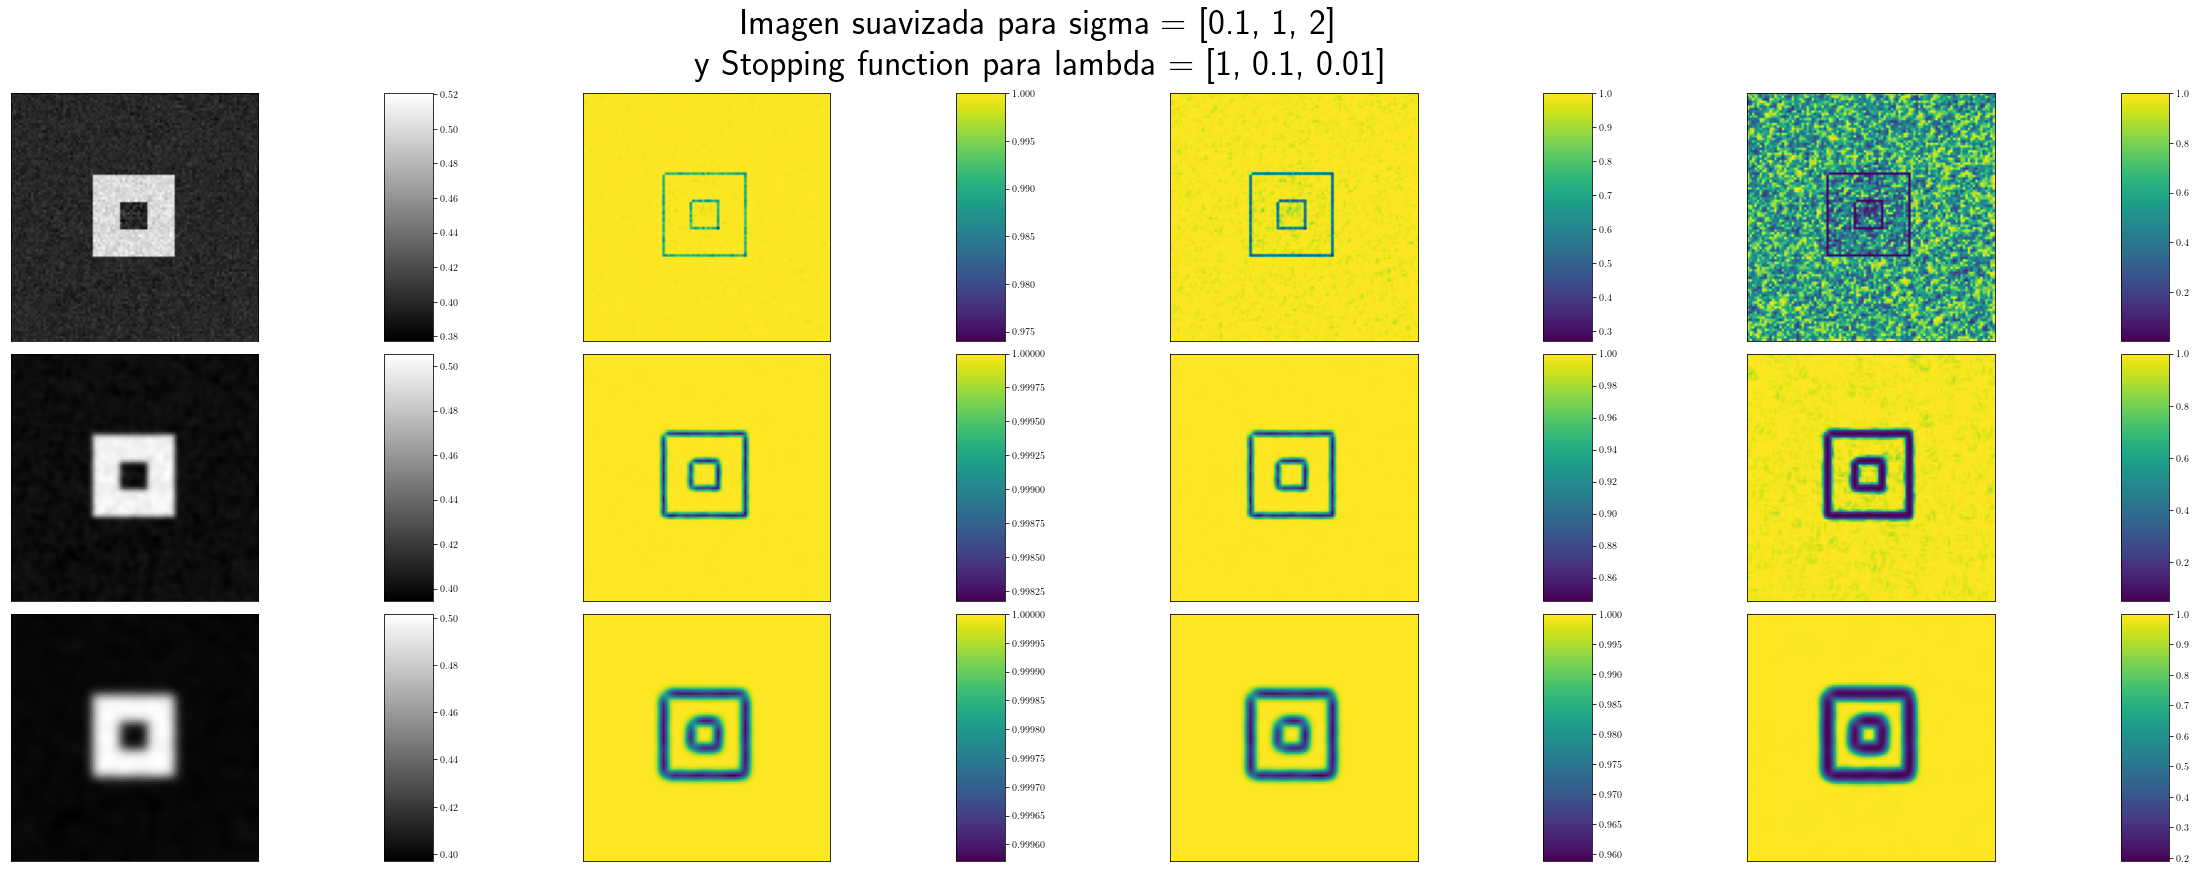

In [5]:
%%time
fig, ax = plt.subplots(3, 4*2, figsize=(4*2*4, 3*4), constrained_layout=True, 
                       gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
for i, sgm in enumerate([0.1, 1, 2]):
    for j, lmbd in enumerate([0, 1, 0.1, 0.01]):
        g, blurred = stopping_func(img, dim, domain, sgm=sgm, lmbd=lmbd)
        if j == 0:
            im = ax[i, j*2].imshow(blurred.reshape(dim[0], dim[1]), cmap='gray')
        else:
            im = ax[i, j*2].imshow(g.reshape(dim[0], dim[1]))
        fig.colorbar(im, cax=ax[i, j*2+1], orientation='vertical')
        ax[i, j*2].set_xticks([])
        ax[i, j*2].set_yticks([])
plt.suptitle("Imagen suavizada para sigma = [0.1, 1, 2] \ny Stopping function para lambda = [1, 0.1, 0.01]", size=18*2)
plt.savefig("stopping_function2.png", bbox_inches='tight');

In [5]:
def initial_curve(x0, r, domain, dim):
    u0 = np.zeros(len(domain))
    for p in domain:
        x = (p[0]/(dim[0]-1), p[1]/(dim[1]-1))
        sgn = 0
        if (x[0]-x0[0]) ** 2 + (x[1]-x0[1]) ** 2 < r ** 2:
            sgn = 1
        else:
            sgn = -1
        dist = abs(r-linalg.norm([x[0]-x0[0], x[1]-x0[1]]))
        ix = domain.index(p)
        u0[ix] = sgn * dist
    return u0

Wall time: 891 ms


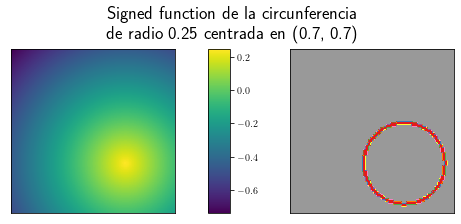

In [15]:
%%time
u0 = initial_curve((0.7, 0.7), 0.25, domain, dim)
fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
im = ax[0].imshow(u0.reshape(dim[0], dim[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im, cax=ax[1], orientation='vertical')
cv0 = np.isclose(u0, 0, atol=0.01)
ax[2].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[2].set_xticks([])
ax[2].set_yticks([]);
plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
# plt.tight_layout();
plt.savefig("u0.png", bbox_inches='tight');

<ipython-input-127-d89a826e3525>:46: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-127-d89a826e3525>:48: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-127-d89a826e3525>:50: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-127-d89a826e3525>:52: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         590.97985768 492.45982255 ... 492.45982255 590.97985768
    0.        ]
 [  0.         492.45982255 393.94846583 ... 393.94846583 492.45982255
    0.        ]
 ...
 [  0.         492.45982255 393.94846583 ... 393.94846583 492.45982255
    0.        ]
 [  0.         590.97985768 492.45982255 ... 492.45982255 590.97985768
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.003988504409790039
D_1: 0.003994941711425781
D: 0.0
D1: 0.00596308708190918
D_1: 0.004004478454589844
D: 0.0
D1: 0.0039522647857666016
D_1: 0.006014585494995117
D: 0.0
D1: 0.004983663558959961
D_1: 0.004987001419067383
D: 0.0
D1: 0.007994651794433594
D_1: 0.00497126579284668
D: 0.0
D1: 0.0050203800201416016
D_1: 0.007975339889526367
D: 0.0
D1: 0.00498652458190918
D_1: 0.009934663772583008
D: 0.0
D1: 0.005983591079711914
D_1: 0.0079803466796875
D: 0.0
D1: 0.00701761245727

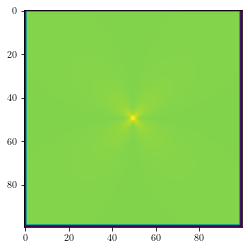

In [128]:
%%time
tau = 5
kappa=-0.1
a, img_blurred = stopping_func(img, dim, domain, sgm=1, lmbd=0.01)
b = np.ones( dim[0] * dim[1] )

u0 = initial_curve((0.5, 0.5), 0.3, domain, dim)

A0_star, B0_star, norm_grad = A_B(u0, a, b, domain, dim, tau, kappa)
plt.imshow(norm_grad)

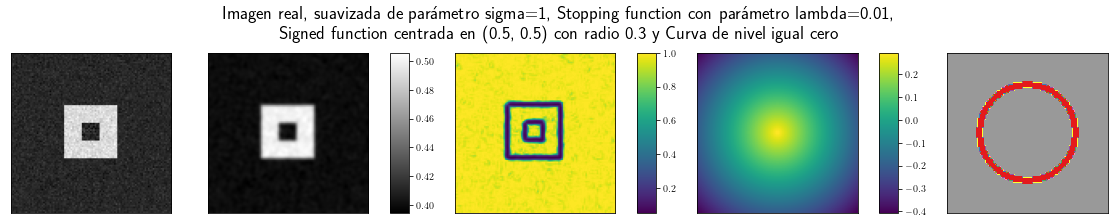

In [92]:
fig, ax = plt.subplots(1, 8, figsize=(5*3+3*0.25, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1, 0.1, 1, 0.1, 1, 0.1, 1]})

ax[0].imshow(img.reshape(dim[0], dim[1]), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(img_blurred.reshape(dim[0], dim[1]), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([]);
fig.colorbar(im, cax=ax[2], orientation='vertical')

im = ax[3].imshow(a.reshape(dim[0], dim[1]))
ax[3].set_xticks([])
ax[3].set_yticks([]);
fig.colorbar(im, cax=ax[4], orientation='vertical')

im = ax[5].imshow(u0.reshape(dim[0], dim[1]))
ax[5].set_xticks([])
ax[5].set_yticks([])
fig.colorbar(im, cax=ax[6], orientation='vertical')

cv0 = np.isclose(u0, 0, atol=0.02)
ax[7].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[7].set_xticks([])
ax[7].set_yticks([]);

plt.suptitle("Imagen real, suavizada de parámetro sigma=1, Stopping function con parámetro lambda=0.01, \nSigned function centrada en (0.5, 0.5) con radio 0.3 y Curva de nivel igual cero", size=18)
plt.savefig("init_exp5.png", bbox_inches='tight');

In [129]:
un = u0
iterations = [u0]
times = [0]

<ipython-input-127-d89a826e3525>:46: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-127-d89a826e3525>:48: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-127-d89a826e3525>:50: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-127-d89a826e3525>:52: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         590.97985768 492.45982255 ... 492.45982255 590.97985768
    0.        ]
 [  0.         492.45982255 393.94846583 ... 393.94846583 492.45982255
    0.        ]
 ...
 [  0.         492.45982255 393.94846583 ... 393.94846583 492.45982255
    0.        ]
 [  0.         590.97985768 492.45982255 ... 492.45982255 590.97985768
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.004961729049682617
D_1: 0.005020618438720703
D: 0.0
D1: 0.00399470329284668
D_1: 0.005944728851318359
D: 0.0
D1: 0.0059778690338134766
D_1: 0.004986763000488281
D: 0.0
D1: 0.010007858276367188
D_1: 0.011958599090576172
D: 0.0
D1: 0.004986286163330078
D_1: 0.0049724578857421875
D: 0.0
D1: 0.00695490837097168
D_1: 0.005984067916870117
D: 0.0
D1: 0.00801849365234375
D_1: 0.0059833526611328125
D: 0.0
D1: 0.005983591079711914
D_1: 0.015351057052612305
D: 0.0
D1: 0.01193022727

D1: 0.018985271453857422
D_1: 0.011970043182373047
D: 0.0
D1: 0.012964963912963867
D_1: 0.012968301773071289
D: 0.0
D1: 0.013922691345214844
D_1: 0.010996580123901367
D: 0.0
D1: 0.013926982879638672
D_1: 0.025969743728637695
D: 0.0
D1: 0.013931751251220703
D_1: 0.01300501823425293
D: 0.0
D1: 0.013941526412963867
D_1: 0.014917373657226562
D: 0.0
D1: 0.018994569778442383
D_1: 0.01495671272277832
D: 0.0
D1: 0.014359712600708008
D_1: 0.015955209732055664
D: 0.0
D1: 0.014956235885620117
D_1: 0.014961957931518555
D: 0.0
D1: 0.014962434768676758
D_1: 0.01491403579711914
D: 0.0
D1: 0.01695561408996582
D_1: 0.016953468322753906
D: 0.0
D1: 0.014978170394897461
D_1: 0.01595306396484375
D: 0.0
D1: 0.015952110290527344
D_1: 0.01596379280090332
D: 0.0
D1: 0.015958547592163086
D_1: 0.01699233055114746
D: 0.0
D1: 0.015918493270874023
D_1: 0.01697254180908203
D: 0.0
D1: 0.03891563415527344
D_1: 0.019919872283935547
D: 0.0
D1: 0.02097797393798828
D_1: 0.017983198165893555
D: 0.0
D1: 0.017966270446777344

D_1: 0.02094411849975586
D: 0.0
D1: 0.027879953384399414
D_1: 0.021937131881713867
D: 0.0
D1: 0.0249478816986084
D_1: 0.02231311798095703
D: 0.0
D1: 0.021958351135253906
D_1: 0.022893428802490234
D: 0.0
D1: 0.02298736572265625
D_1: 0.021938800811767578
D: 0.0
D1: 0.02516484260559082
D_1: 0.02194070816040039
D: 0.0
D1: 0.025946855545043945
D_1: 0.036870718002319336
D: 0.0
D1: 0.030920028686523438
D_1: 0.033956289291381836
D: 0.0
D1: 0.022933483123779297
D_1: 0.024928569793701172
D: 0.0
D1: 0.02298879623413086
D_1: 0.024924755096435547
D: 0.0
D1: 0.023943185806274414
D_1: 0.025925636291503906
D: 0.0
D1: 0.023951292037963867
D_1: 0.026949167251586914
D: 0.0
D1: 0.025898456573486328
D_1: 0.024971723556518555
D: 0.0
D1: 0.026913881301879883
D_1: 0.023950576782226562
D: 0.0
D1: 0.02696514129638672
D_1: 0.02592325210571289
D: 0.0
D1: 0.02892303466796875
D_1: 0.026705503463745117
D: 0.0
D1: 0.026413440704345703
D_1: 0.027937650680541992
D: 0.0
D1: 0.02494192123413086
D_1: 0.02492666244506836
D

D1: 0.03191733360290527
D_1: 0.03191709518432617
D: 0.0
D1: 0.03190946578979492
D_1: 0.03287816047668457
D: 0.0
D1: 0.03291893005371094
D_1: 0.03386354446411133
D: 0.0010151863098144531
D1: 0.0308992862701416
D_1: 0.033908843994140625
D: 0.0
D1: 0.03390932083129883
D_1: 0.03291201591491699
D: 0.0
D1: 0.032912254333496094
D_1: 0.03295135498046875
D: 0.0
D1: 0.03187227249145508
D_1: 0.038323163986206055
n: 3 time: 15.188940525054932
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         838.03836882 806.46163299 ... 806.57803754 838.13389771
    0.        ]
 [  0.         573.33306178 533.68222227 ... 533.8599245  573.42226875
    0.        ]
 ...
 [  0.         573.41053042 533.79726646 ... 533.55676674 573.09148999
    0.        ]
 [  0.         838.10444598 806.54408291 ... 806.44263025 838.01660884
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.004986286163330078
D_1: 0.00398921966552

D_1: 0.013962507247924805
D: 0.0
D1: 0.01500082015991211
D_1: 0.01296234130859375
D: 0.0
D1: 0.010970830917358398
D_1: 0.011966466903686523
D: 0.0
D1: 0.011968851089477539
D_1: 0.012997865676879883
D: 0.0
D1: 0.012940168380737305
D_1: 0.012964010238647461
D: 0.0
D1: 0.012965202331542969
D_1: 0.015957355499267578
D: 0.0
D1: 0.013962507247924805
D_1: 0.015956878662109375
D: 0.0
D1: 0.01395726203918457
D_1: 0.01396322250366211
D: 0.0
D1: 0.014959573745727539
D_1: 0.027928590774536133
D: 0.0
D1: 0.013955831527709961
D_1: 0.013962507247924805
D: 0.0
D1: 0.01598381996154785
D_1: 0.014969348907470703
D: 0.0
D1: 0.014923572540283203
D_1: 0.016954421997070312
D: 0.0
D1: 0.01695394515991211
D_1: 0.015958070755004883
D: 0.0
D1: 0.015957355499267578
D_1: 0.015957355499267578
D: 0.0
D1: 0.015957355499267578
D_1: 0.015956878662109375
D: 0.0
D1: 0.01795196533203125
D_1: 0.014960289001464844
D: 0.0
D1: 0.016986370086669922
D_1: 0.017931222915649414
D: 0.0
D1: 0.016980648040771484
D_1: 0.03488039970397

D1: 0.022973299026489258
D_1: 0.021939754486083984
D: 0.0
D1: 0.021941184997558594
D_1: 0.023936986923217773
D: 0.0
D1: 0.022945165634155273
D_1: 0.02193593978881836
D: 0.0
D1: 0.024972200393676758
D_1: 0.02389693260192871
D: 0.0
D1: 0.025936126708984375
D_1: 0.023930788040161133
D: 0.0
D1: 0.024933338165283203
D_1: 0.022938966751098633
D: 0.0
D1: 0.024939775466918945
D_1: 0.02293229103088379
D: 0.0
D1: 0.04587674140930176
D_1: 0.0359044075012207
D: 0.0
D1: 0.024933338165283203
D_1: 0.024972200393676758
D: 0.0
D1: 0.024901866912841797
D_1: 0.023957252502441406
D: 0.0010023117065429688
D1: 0.024889230728149414
D_1: 0.026911497116088867
D: 0.0
D1: 0.023970365524291992
D_1: 0.023899555206298828
D: 0.0
D1: 0.022958993911743164
D_1: 0.027892351150512695
D: 0.0
D1: 0.02631855010986328
D_1: 0.02594923973083496
D: 0.0
D1: 0.024907827377319336
D_1: 0.02597188949584961
D: 0.0
D1: 0.02393651008605957
D_1: 0.0268862247467041
D: 0.0
D1: 0.023962020874023438
D_1: 0.02793741226196289
D: 0.0
D1: 0.027

D_1: 0.03793811798095703
D: 0.0
D1: 0.03785896301269531
D_1: 0.04188799858093262
D: 0.0
D1: 0.04488039016723633
D_1: 0.04288506507873535
D: 0.0
D1: 0.03239774703979492
D_1: 0.03193330764770508
D: 0.0
D1: 0.03290724754333496
D_1: 0.03589963912963867
D: 0.0
D1: 0.036904096603393555
D_1: 0.032918453216552734
D: 0.0
D1: 0.03885030746459961
D_1: 0.03291440010070801
D: 0.0
D1: 0.03495359420776367
D_1: 0.032866477966308594
D: 0.0
D1: 0.03395509719848633
D_1: 0.033908843994140625
n: 7 time: 15.460753202438354
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         844.47111993 818.55062608 ... 818.65672734 844.54160273
    0.        ]
 [  0.         590.92299197 558.77385646 ... 558.96832996 591.06032107
    0.        ]
 ...
 [  0.         591.04287714 558.93714327 ... 558.91474359 591.01273075
    0.        ]
 [  0.         844.53529524 818.64097763 ... 818.61249714 844.50397567
    0.        ]
 [  0.           0.           0.         ...   0.           0

D_1: 0.010005474090576172
D: 0.0
D1: 0.008985280990600586
D_1: 0.008972644805908203
D: 0.0
D1: 0.009003162384033203
D_1: 0.009939908981323242
D: 0.0
D1: 0.008976459503173828
D_1: 0.010010719299316406
D: 0.0
D1: 0.008980512619018555
D_1: 0.009972095489501953
D: 0.0
D1: 0.010946035385131836
D_1: 0.008995532989501953
D: 0.0
D1: 0.011972665786743164
D_1: 0.01099848747253418
D: 0.0
D1: 0.009981393814086914
D_1: 0.010982990264892578
D: 0.0
D1: 0.011945962905883789
D_1: 0.009964704513549805
D: 0.0
D1: 0.011973857879638672
D_1: 0.010953903198242188
D: 0.0
D1: 0.014934062957763672
D_1: 0.010260343551635742
D: 0.0
D1: 0.012970924377441406
D_1: 0.011962890625
D: 0.0
D1: 0.011971473693847656
D_1: 0.011016368865966797
D: 0.0
D1: 0.013010740280151367
D_1: 0.012959718704223633
D: 0.0
D1: 0.013006925582885742
D_1: 0.01097726821899414
D: 0.0
D1: 0.01394033432006836
D_1: 0.01398015022277832
D: 0.0
D1: 0.013983488082885742
D_1: 0.017961978912353516
D: 0.0
D1: 0.02023148536682129
D_1: 0.01360630989074707


D1: 0.027912616729736328
D_1: 0.029920101165771484
D: 0.0
D1: 0.029918432235717773
D_1: 0.018949270248413086
D: 0.0
D1: 0.018995046615600586
D_1: 0.021895647048950195
D: 0.0
D1: 0.01998734474182129
D_1: 0.01995539665222168
D: 0.0
D1: 0.018958330154418945
D_1: 0.019941091537475586
D: 0.0
D1: 0.02293992042541504
D_1: 0.023889541625976562
D: 0.0
D1: 0.020944833755493164
D_1: 0.02095198631286621
D: 0.0
D1: 0.02195143699645996
D_1: 0.018941640853881836
D: 0.0
D1: 0.02193903923034668
D_1: 0.02092742919921875
D: 0.0
D1: 0.01994633674621582
D_1: 0.019932031631469727
D: 0.0
D1: 0.019281625747680664
D_1: 0.020940780639648438
D: 0.0
D1: 0.02094745635986328
D_1: 0.02094292640686035
D: 0.0
D1: 0.020944833755493164
D_1: 0.019946813583374023
D: 0.0
D1: 0.020987987518310547
D_1: 0.022934913635253906
D: 0.0
D1: 0.021982192993164062
D_1: 0.01995086669921875
D: 0.0
D1: 0.023935317993164062
D_1: 0.021945714950561523
D: 0.0
D1: 0.021941423416137695
D_1: 0.025886058807373047
D: 0.0
D1: 0.03492331504821777
D

D1: 0.03194546699523926
D_1: 0.03288388252258301
D: 0.0
D1: 0.03094196319580078
D_1: 0.033884286880493164
D: 0.0
D1: 0.027924776077270508
D_1: 0.02792525291442871
D: 0.0
D1: 0.027925968170166016
D_1: 0.02892589569091797
D: 0.0
D1: 0.029909610748291016
D_1: 0.02991962432861328
D: 0.0
D1: 0.029920101165771484
D_1: 0.030918359756469727
D: 0.0
D1: 0.029917240142822266
D_1: 0.02996659278869629
D: 0.0
D1: 0.03287196159362793
D_1: 0.03490805625915527
D: 0.0
D1: 0.03390812873840332
D_1: 0.03390955924987793
D: 0.0
D1: 0.03490281105041504
D_1: 0.033908843994140625
D: 0.0
D1: 0.036894798278808594
D_1: 0.03590226173400879
D: 0.0009975433349609375
D1: 0.04291200637817383
D_1: 0.0378720760345459
D: 0.0
D1: 0.034906625747680664
D_1: 0.03690218925476074
D: 0.0
D1: 0.035903215408325195
D_1: 0.03490638732910156
D: 0.0
D1: 0.036885738372802734
D_1: 0.039927005767822266
n: 11 time: 15.286284685134888
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         848.45926269

D: 0.0
D1: 0.007977724075317383
D_1: 0.007979154586791992
D: 0.0
D1: 0.013966083526611328
D_1: 0.013091802597045898
D: 0.0
D1: 0.00999903678894043
D_1: 0.008975028991699219
D: 0.0
D1: 0.00897526741027832
D_1: 0.00895071029663086
D: 0.0
D1: 0.007994651794433594
D_1: 0.009987354278564453
D: 0.0
D1: 0.01296544075012207
D_1: 0.0099334716796875
D: 0.0
D1: 0.011003971099853516
D_1: 0.009974956512451172
D: 0.0
D1: 0.010970354080200195
D_1: 0.010936498641967773
D: 0.0
D1: 0.009925365447998047
D_1: 0.01101231575012207
D: 0.0
D1: 0.011965513229370117
D_1: 0.014959096908569336
D: 0.0
D1: 0.01201009750366211
D_1: 0.011969804763793945
D: 0.0
D1: 0.01391911506652832
D_1: 0.013004302978515625
D: 0.0
D1: 0.010977029800415039
D_1: 0.01396036148071289
D: 0.0
D1: 0.013964414596557617
D_1: 0.01291799545288086
D: 0.0
D1: 0.01197504997253418
D_1: 0.016960620880126953
D: 0.0009925365447998047
D1: 0.012005090713500977
D_1: 0.01392364501953125
D: 0.0
D1: 0.014996528625488281
D_1: 0.012963533401489258
D: 0.0
D1

D_1: 0.016949176788330078
D: 0.0
D1: 0.021902799606323242
D_1: 0.029942035675048828
D: 0.0
D1: 0.02891397476196289
D_1: 0.028923988342285156
D: 0.0
D1: 0.021969318389892578
D_1: 0.019917964935302734
D: 0.0
D1: 0.017992258071899414
D_1: 0.019988059997558594
D: 0.0
D1: 0.019916057586669922
D_1: 0.017991065979003906
D: 0.0
D1: 0.018951892852783203
D_1: 0.01890850067138672
D: 0.0
D1: 0.023935556411743164
D_1: 0.02293848991394043
D: 0.0
D1: 0.028963327407836914
D_1: 0.0308835506439209
D: 0.0
D1: 0.019980669021606445
D_1: 0.022936105728149414
D: 0.0
D1: 0.021944284439086914
D_1: 0.026931285858154297
D: 0.0
D1: 0.02393651008605957
D_1: 0.02991962432861328
D: 0.0
D1: 0.021940231323242188
D_1: 0.024936437606811523
D: 0.0
D1: 0.022939205169677734
D_1: 0.02293705940246582
D: 0.0
D1: 0.023918628692626953
D_1: 0.021942853927612305
D: 0.0
D1: 0.02496957778930664
D_1: 0.021941423416137695
D: 0.0
D1: 0.022938251495361328
D_1: 0.02292656898498535
D: 0.0
D1: 0.021955251693725586
D_1: 0.02489352226257324

D_1: 0.030889272689819336
D: 0.0
D1: 0.027965545654296875
D_1: 0.03191113471984863
D: 0.0
D1: 0.03091287612915039
D_1: 0.03092050552368164
D: 0.0
D1: 0.02991938591003418
D_1: 0.030870676040649414
D: 0.0
D1: 0.030961990356445312
D_1: 0.030954837799072266
D: 0.0
D1: 0.03191542625427246
D_1: 0.03291511535644531
D: 0.0
D1: 0.03107762336730957
D_1: 0.03091716766357422
D: 0.0
D1: 0.03294730186462402
D_1: 0.03391432762145996
D: 0.0
D1: 0.034896135330200195
D_1: 0.035895586013793945
D: 0.0
D1: 0.04088735580444336
D_1: 0.035904884338378906
D: 0.0
D1: 0.036901235580444336
D_1: 0.043885231018066406
D: 0.0
D1: 0.039890289306640625
D_1: 0.03915739059448242
D: 0.0
D1: 0.03361034393310547
D_1: 0.03659677505493164
D: 0.0
D1: 0.03291201591491699
D_1: 0.03490614891052246
D: 0.0
D1: 0.031914710998535156
D_1: 0.03191518783569336
D: 0.0
D1: 0.03191423416137695
D_1: 0.03191518783569336
D: 0.0
D1: 0.03352046012878418
D_1: 0.033901214599609375
D: 0.0
D1: 0.03391718864440918
D_1: 0.032903432846069336
D: 0.0
D1

D: 0.0
D1: 0.007977008819580078
D_1: 0.008971214294433594
D: 0.0
D1: 0.008932113647460938
D_1: 0.009020566940307617
D: 0.0
D1: 0.007980823516845703
D_1: 0.00897216796875
D: 0.0
D1: 0.008933544158935547
D_1: 0.009018659591674805
D: 0.0
D1: 0.008973121643066406
D_1: 0.008975982666015625
D: 0.0
D1: 0.008975505828857422
D_1: 0.008978843688964844
D: 0.0
D1: 0.009976625442504883
D_1: 0.00995326042175293
D: 0.0
D1: 0.008980274200439453
D_1: 0.009994983673095703
D: 0.0
D1: 0.009987115859985352
D_1: 0.010957002639770508
D: 0.0
D1: 0.009948492050170898
D_1: 0.01099538803100586
D: 0.0
D1: 0.010946035385131836
D_1: 0.010929346084594727
D: 0.0
D1: 0.012009620666503906
D_1: 0.011970758438110352
D: 0.0
D1: 0.011976003646850586
D_1: 0.010961532592773438
D: 0.0
D1: 0.011967897415161133
D_1: 0.011970043182373047
D: 0.0
D1: 0.01196599006652832
D_1: 0.01097249984741211
D: 0.0
D1: 0.011965274810791016
D_1: 0.01396632194519043
D: 0.0
D1: 0.013965845108032227
D_1: 0.011960744857788086
D: 0.001023769378662109

D1: 0.01795220375061035
D_1: 0.017939090728759766
D: 0.0
D1: 0.01796412467956543
D_1: 0.016943693161010742
D: 0.0
D1: 0.01793503761291504
D_1: 0.017937898635864258
D: 0.0
D1: 0.01896524429321289
D_1: 0.019947290420532227
D: 0.0
D1: 0.025916337966918945
D_1: 0.022977828979492188
D: 0.0
D1: 0.026886940002441406
D_1: 0.02293992042541504
D: 0.0
D1: 0.021923303604125977
D_1: 0.020981788635253906
D: 0.0
D1: 0.026914119720458984
D_1: 0.025905609130859375
D: 0.0
D1: 0.02796316146850586
D_1: 0.02392292022705078
D: 0.0
D1: 0.022937774658203125
D_1: 0.025905847549438477
D: 0.0
D1: 0.02292919158935547
D_1: 0.024930715560913086
D: 0.0
D1: 0.023935317993164062
D_1: 0.02321648597717285
D: 0.0
D1: 0.02098560333251953
D_1: 0.020943164825439453
D: 0.0
D1: 0.02190256118774414
D_1: 0.0229642391204834
D: 0.0
D1: 0.02295398712158203
D_1: 0.0348660945892334
D: 0.0
D1: 0.024969100952148438
D_1: 0.03393363952636719
D: 0.0
D1: 0.0229034423828125
D_1: 0.0249786376953125
D: 0.0
D1: 0.02390265464782715
D_1: 0.0249

D1: 0.029916763305664062
D_1: 0.03087592124938965
D: 0.0
D1: 0.03388357162475586
D_1: 0.03495049476623535
D: 0.0
D1: 0.03195977210998535
D_1: 0.03091740608215332
D: 0.0
D1: 0.030913591384887695
D_1: 0.030925512313842773
D: 0.0
D1: 0.029960155487060547
D_1: 0.027927637100219727
D: 0.0
D1: 0.033865928649902344
D_1: 0.032912254333496094
D: 0.0
D1: 0.030919790267944336
D_1: 0.032915592193603516
D: 0.0
D1: 0.030866146087646484
D_1: 0.030944347381591797
D: 0.0
D1: 0.030917644500732422
D_1: 0.02991509437561035
D: 0.0
D1: 0.03391265869140625
D_1: 0.03488731384277344
D: 0.0
D1: 0.03991341590881348
D_1: 0.031868696212768555
D: 0.0
D1: 0.032944440841674805
D_1: 0.03391528129577637
D: 0.0
D1: 0.03585672378540039
D_1: 0.032927751541137695
n: 19 time: 16.332517623901367
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         852.71663518 830.24137156 ... 830.28920782 852.74908761
    0.        ]
 [  0.         606.21743566 579.86489269 ... 579.95248567 606.27906

<timed exec>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


n: 20 time: 15.740923166275024
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         853.07698966 830.74907981 ... 830.79434969 853.10772662
    0.        ]
 [  0.         606.87581672 580.77526715 ... 580.85813632 606.93410982
    0.        ]
 ...
 [  0.         606.91537267 580.83043035 ... 580.79990177 606.88980585
    0.        ]
 [  0.         853.09854834 830.77950948 ... 830.75796553 853.08048977
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.0040247440338134766
D_1: 0.0029921531677246094
D: 0.0009610652923583984
D1: 0.004014253616333008
D_1: 0.006002902984619141
D: 0.0
D1: 0.0049839019775390625
D_1: 0.0039746761322021484
D: 0.0
D1: 0.005957841873168945
D_1: 0.005032062530517578
D: 0.0
D1: 0.004981279373168945
D_1: 0.006939888000488281
D: 0.0
D1: 0.005035877227783203
D_1: 0.005975961685180664
D: 0.0
D1: 0.006987810134887695
D_1: 0.0059812068939208984
D: 0.0
D1: 0.005981683731079

D_1: 0.014960050582885742
D: 0.0
D1: 0.012964963912963867
D_1: 0.013953208923339844
D: 0.0
D1: 0.015958309173583984
D_1: 0.014215946197509766
D: 0.0
D1: 0.01694798469543457
D_1: 0.014986038208007812
D: 0.0009884834289550781
D1: 0.014967918395996094
D_1: 0.01596975326538086
D: 0.0
D1: 0.01598334312438965
D_1: 0.014967918395996094
D: 0.0
D1: 0.015998125076293945
D_1: 0.016947269439697266
D: 0.0
D1: 0.015982627868652344
D_1: 0.015999794006347656
D: 0.0
D1: 0.015995264053344727
D_1: 0.016960620880126953
D: 0.0009963512420654297
D1: 0.028922557830810547
D_1: 0.023961544036865234
D: 0.0
D1: 0.021953344345092773
D_1: 0.018952369689941406
D: 0.0
D1: 0.016945600509643555
D_1: 0.016967296600341797
D: 0.0
D1: 0.016991376876831055
D_1: 0.02094411849975586
D: 0.0
D1: 0.019908666610717773
D_1: 0.019989490509033203
D: 0.0
D1: 0.01894831657409668
D_1: 0.017907142639160156
D: 0.0
D1: 0.02090311050415039
D_1: 0.028949499130249023
D: 0.0
D1: 0.026940107345581055
D_1: 0.029942750930786133
D: 0.0
D1: 0.019

D1: 0.02295851707458496
D_1: 0.029964685440063477
D: 0.0
D1: 0.026882171630859375
D_1: 0.024932861328125
D: 0.0
D1: 0.024930715560913086
D_1: 0.02293848991394043
D: 0.0
D1: 0.024933338165283203
D_1: 0.02345442771911621
D: 0.0
D1: 0.025968551635742188
D_1: 0.02392411231994629
D: 0.0
D1: 0.02597332000732422
D_1: 0.023918628692626953
D: 0.0
D1: 0.026943445205688477
D_1: 0.02992081642150879
D: 0.0
D1: 0.024918317794799805
D_1: 0.03189563751220703
D: 0.0
D1: 0.02697300910949707
D_1: 0.030873537063598633
D: 0.0
D1: 0.03295135498046875
D_1: 0.025932788848876953
D: 0.0
D1: 0.0279080867767334
D_1: 0.02794504165649414
D: 0.0
D1: 0.02592635154724121
D_1: 0.027959585189819336
D: 0.0
D1: 0.02792525291442871
D_1: 0.025928974151611328
D: 0.0
D1: 0.02796626091003418
D_1: 0.0269320011138916
D: 0.0
D1: 0.026929140090942383
D_1: 0.029915809631347656
D: 0.0
D1: 0.02891826629638672
D_1: 0.026929616928100586
D: 0.0
D1: 0.028925180435180664
D_1: 0.03291654586791992
D: 0.0
D1: 0.029917001724243164
D_1: 0.0288

D_1: 0.03686094284057617
D: 0.0
D1: 0.04089045524597168
D_1: 0.04886937141418457
n: 24 time: 15.958142518997192
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         854.30241651 832.47449008 ... 832.51151975 854.32762819
    0.        ]
 [  0.         609.1095992  583.86781026 ... 583.93553094 609.15719802
    0.        ]
 ...
 [  0.         609.14244022 583.91361789 ... 583.88489941 609.11906358
    0.        ]
 [  0.         854.32044029 832.49985012 ... 832.48039633 854.30451708
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.004026651382446289
D_1: 0.003987789154052734
D: 0.0
D1: 0.005959987640380859
D_1: 0.004973649978637695
D: 0.0
D1: 0.005014896392822266
D_1: 0.005955696105957031
D: 0.0
D1: 0.005024909973144531
D_1: 0.0049839019775390625
D: 0.0
D1: 0.00994729995727539
D_1: 0.005022287368774414
D: 0.0
D1: 0.006981372833251953
D_1: 0.005988597869873047
D: 0.0
D1: 0.006942033767700

D_1: 0.010971307754516602
D: 0.0
D1: 0.010973215103149414
D_1: 0.010968208312988281
D: 0.0
D1: 0.012979507446289062
D_1: 0.012926816940307617
D: 0.0
D1: 0.012007951736450195
D_1: 0.012970209121704102
D: 0.0
D1: 0.014957666397094727
D_1: 0.013960838317871094
D: 0.0
D1: 0.012967824935913086
D_1: 0.01593470573425293
D: 0.0
D1: 0.013930082321166992
D_1: 0.01225900650024414
D: 0.0
D1: 0.012965202331542969
D_1: 0.012930631637573242
D: 0.0
D1: 0.014980316162109375
D_1: 0.014972448348999023
D: 0.0
D1: 0.012952566146850586
D_1: 0.014974355697631836
D: 0.0
D1: 0.014945030212402344
D_1: 0.014972686767578125
D: 0.0
D1: 0.014963865280151367
D_1: 0.014948844909667969
D: 0.0
D1: 0.016988754272460938
D_1: 0.014962434768676758
D: 0.0
D1: 0.014958381652832031
D_1: 0.016968965530395508
D: 0.0
D1: 0.016953468322753906
D_1: 0.015996456146240234
D: 0.0
D1: 0.016949176788330078
D_1: 0.016921281814575195
D: 0.0009975433349609375
D1: 0.015956878662109375
D_1: 0.015957355499267578
D: 0.0
D1: 0.03490614891052246

D_1: 0.03288698196411133
D: 0.0
D1: 0.03192591667175293
D_1: 0.03293585777282715
D: 0.0
D1: 0.022953271865844727
D_1: 0.023895740509033203
D: 0.0
D1: 0.02198648452758789
D_1: 0.02340555191040039
D: 0.0
D1: 0.023936033248901367
D_1: 0.023975849151611328
D: 0.0
D1: 0.025926589965820312
D_1: 0.02294135093688965
D: 0.0
D1: 0.02489471435546875
D_1: 0.02293848991394043
D: 0.0
D1: 0.02697277069091797
D_1: 0.022939205169677734
D: 0.0
D1: 0.029915571212768555
D_1: 0.025893449783325195
D: 0.0
D1: 0.02497100830078125
D_1: 0.02692723274230957
D: 0.0
D1: 0.02693033218383789
D_1: 0.027884960174560547
D: 0.0
D1: 0.026929140090942383
D_1: 0.026926517486572266
D: 0.0
D1: 0.0269625186920166
D_1: 0.023942947387695312
D: 0.0
D1: 0.026917695999145508
D_1: 0.02792835235595703
D: 0.0
D1: 0.024923086166381836
D_1: 0.0269014835357666
D: 0.0
D1: 0.025922536849975586
D_1: 0.026966571807861328
D: 0.0
D1: 0.02791285514831543
D_1: 0.02893662452697754
D: 0.0
D1: 0.02695775032043457
D_1: 0.02892160415649414
D: 0.0
D1

D1: 0.03295111656188965
D_1: 0.035904884338378906
D: 0.0
D1: 0.03195500373840332
D_1: 0.03391671180725098
D: 0.0
D1: 0.030913591384887695
D_1: 0.03092050552368164
D: 0.0
D1: 0.033963918685913086
D_1: 0.03390312194824219
n: 28 time: 15.508852481842041
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         855.27295878 833.84004613 ... 833.87114102 855.29417076
    0.        ]
 [  0.         610.8732747  586.31397315 ... 586.37080809 610.91319051
    0.        ]
 ...
 [  0.         610.90269396 586.35500228 ... 586.32911626 610.8819458
    0.        ]
 [  0.         855.2892007  833.86284117 ... 833.8456829  855.27534047
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.0029926300048828125
D_1: 0.00398564338684082
D: 0.0
D1: 0.004961490631103516
D_1: 0.004964590072631836
D: 0.0
D1: 0.003989696502685547
D_1: 0.00498652458190918
D: 0.0
D1: 0.0059967041015625
D_1: 0.004987001419067383
D: 0.0
D1

D: 0.0
D1: 0.01200723648071289
D_1: 0.011967182159423828
D: 0.0
D1: 0.010957717895507812
D_1: 0.011981487274169922
D: 0.000957489013671875
D1: 0.01196908950805664
D_1: 0.013003826141357422
D: 0.0
D1: 0.010969877243041992
D_1: 0.013964653015136719
D: 0.0
D1: 0.012949943542480469
D_1: 0.013938426971435547
D: 0.0
D1: 0.012942075729370117
D_1: 0.012987613677978516
D: 0.0
D1: 0.011992454528808594
D_1: 0.01396322250366211
D: 0.0
D1: 0.014973163604736328
D_1: 0.014959573745727539
D: 0.0
D1: 0.013962030410766602
D_1: 0.013976812362670898
D: 0.0
D1: 0.013948440551757812
D_1: 0.014962196350097656
D: 0.0
D1: 0.015958786010742188
D_1: 0.017946481704711914
D: 0.0
D1: 0.015965700149536133
D_1: 0.015954017639160156
D: 0.0
D1: 0.015941619873046875
D_1: 0.014960289001464844
D: 0.0
D1: 0.015982627868652344
D_1: 0.01595783233642578
D: 0.0
D1: 0.015995025634765625
D_1: 0.015960693359375
D: 0.0
D1: 0.014957904815673828
D_1: 0.016916275024414062
D: 0.0
D1: 0.015997886657714844
D_1: 0.015957355499267578
D: 0

D1: 0.021976470947265625
D_1: 0.02090907096862793
D: 0.0
D1: 0.03191494941711426
D_1: 0.034911394119262695
D: 0.0
D1: 0.030915498733520508
D_1: 0.03291487693786621
D: 0.0
D1: 0.03391385078430176
D_1: 0.031914472579956055
D: 0.0
D1: 0.04488039016723633
D_1: 0.03789854049682617
D: 0.0
D1: 0.03590583801269531
D_1: 0.035909175872802734
D: 0.0
D1: 0.04288649559020996
D_1: 0.03490734100341797
D: 0.0
D1: 0.042885780334472656
D_1: 0.03292059898376465
D: 0.0
D1: 0.030917644500732422
D_1: 0.026929378509521484
D: 0.0
D1: 0.030916213989257812
D_1: 0.04687666893005371
D: 0.0
D1: 0.030916213989257812
D_1: 0.033910512924194336
D: 0.0
D1: 0.03291130065917969
D_1: 0.029918909072875977
D: 0.0
D1: 0.03291010856628418
D_1: 0.03195691108703613
D: 0.0
D1: 0.03287243843078613
D_1: 0.04491758346557617
D: 0.0
D1: 0.03885674476623535
D_1: 0.03391909599304199
D: 0.0
D1: 0.03589630126953125
D_1: 0.035901546478271484
D: 0.0
D1: 0.026927709579467773
D_1: 0.03191494941711426
D: 0.0
D1: 0.028923988342285156
D_1: 0.03

D_1: 0.03291201591491699
D: 0.0
D1: 0.03490591049194336
D_1: 0.031941890716552734
D: 0.0
D1: 0.0449066162109375
D_1: 0.03489875793457031
D: 0.0
D1: 0.0359044075012207
D_1: 0.03291177749633789
D: 0.0
D1: 0.03691983222961426
D_1: 0.03389143943786621
D: 0.0
D1: 0.03490591049194336
D_1: 0.034906864166259766
D: 0.0
D1: 0.03390932083129883
D_1: 0.03291153907775879
n: 32 time: 16.033169984817505
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         856.06855915 834.95897094 ... 834.98558932 856.08673857
    0.        ]
 [  0.         612.31540545 588.31730274 ... 588.36594474 612.34953645
    0.        ]
 ...
 [  0.         612.34330903 588.35621597 ... 588.3333978  612.32517439
    0.        ]
 [  0.         856.08403689 834.98065658 ... 834.96570011 856.0720391
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
D: 0.0
D1: 0.00602412223815918
D_1: 0.0039479732513427734
D: 0.0
D1: 0.005022525787353516
D_1: 0.

KeyboardInterrupt: 

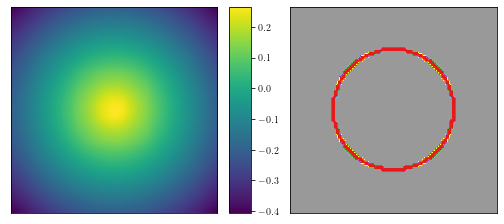

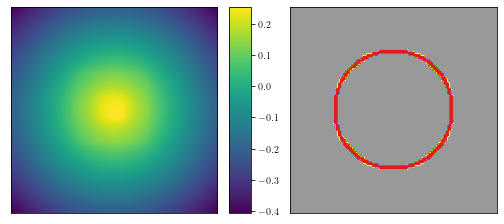

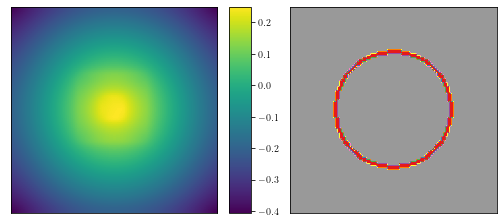

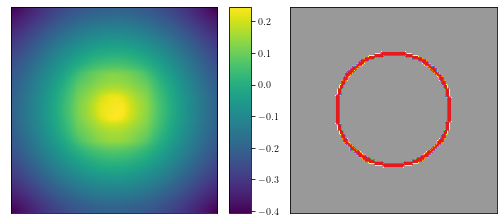

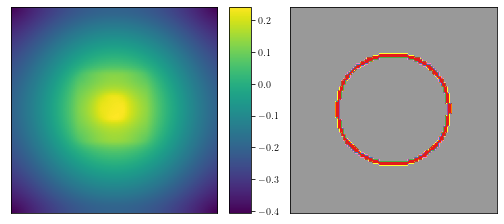

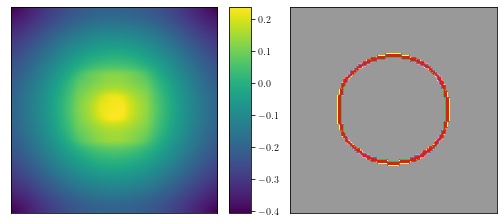

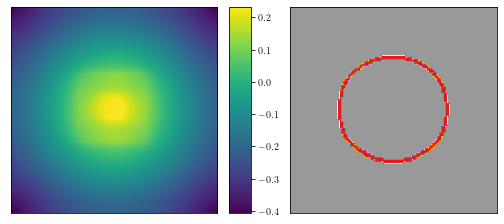

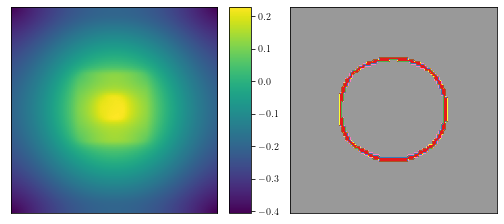

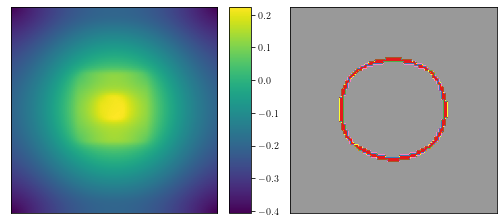

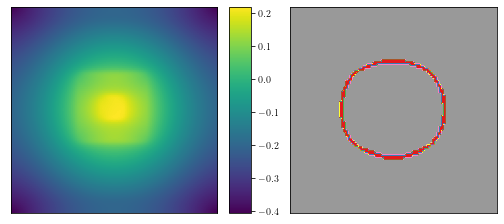

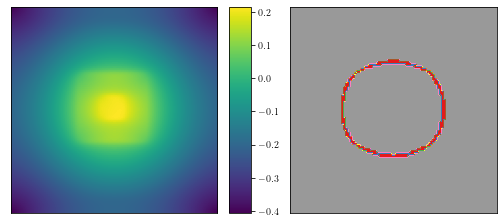

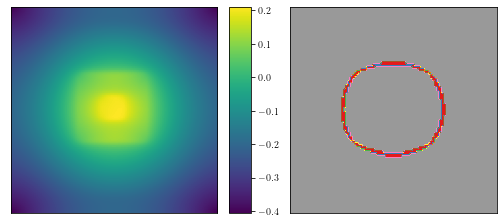

In [ ]:
%%time
for n in range(50):
    
    start = time.time()
    An_star, Bn_star, _ = A_B(un, a, b, domain, dim, tau, kappa)
    un1 = spsolve(An_star, Bn_star)
    cvn = np.isclose(un1, 0, atol=0.01)

    fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
    im = ax[0].imshow(un1.reshape(dim[0], dim[1]))
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    fig.colorbar(im, cax=ax[1], orientation='vertical')

    ax[2].imshow(cvn.reshape(dim[0], dim[1]), cmap="Set1_r")
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);
    # plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
    # plt.tight_layout();
    plt.savefig(f"image_test6/un_{n}.png", bbox_inches='tight');

    un = un1
    iterations.append(un)
    end = time.time()
    
    times.append(end-start)
    print("n:", n, "time:", times[-1])

In [42]:
pickle.dump(iterations, open("iterations0.pickle", "wb"))
pickle.dump(times, open("times0.pickle", "wb"))

mean: 35.06385461143825 std: 0.5625724966687793


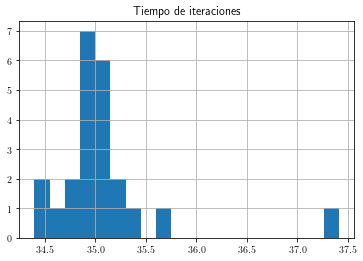

In [79]:
rel_times = times[1:23+1]
pd.DataFrame(rel_times, columns=["Tiempo de iteraciones"]).hist(bins=20);
print("mean:", np.mean(rel_times), "std:", np.std(rel_times))

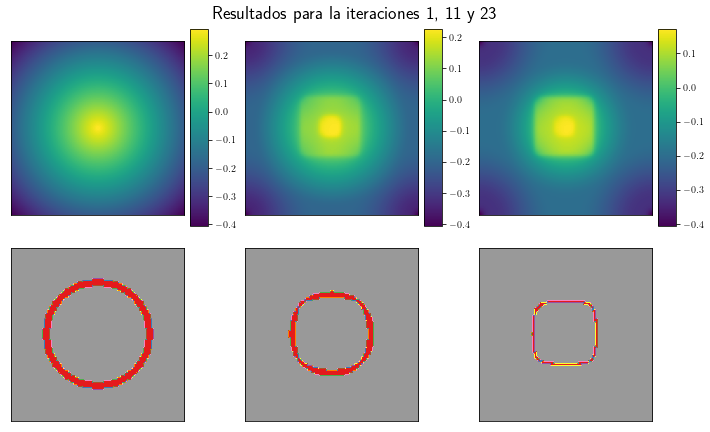

In [91]:
fig, ax = plt.subplots(2, 6, figsize=(3*3+3*0.25, 3*2), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1]})

# Funciones
im = ax[0, 0].imshow(iterations[0].reshape(dim[0], dim[1]))
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

fig.colorbar(im, cax=ax[0, 1], orientation='vertical')

im = ax[0, 2].imshow(iterations[11].reshape(dim[0], dim[1]))
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fig.colorbar(im, cax=ax[0, 3], orientation='vertical')

im = ax[0, 4].imshow(iterations[23].reshape(dim[0], dim[1]))
ax[0, 4].set_xticks([])
ax[0, 4].set_yticks([])

fig.colorbar(im, cax=ax[0, 5], orientation='vertical')

# Curvas
im = ax[1, 0].imshow(np.isclose(iterations[0], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

im = ax[1, 2].imshow(np.isclose(iterations[11], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

im = ax[1, 4].imshow(np.isclose(iterations[23], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 4].set_xticks([])
ax[1, 4].set_yticks([])

for axc in [ax[1, 1], ax[1, 3], ax[1, 5]]:
    axc.remove()

plt.suptitle("Resultados para la iteraciones 1, 11 y 23", size=18)
plt.savefig("res_exp5.png", bbox_inches='tight');